# BE - Benign Equivalized

In [1]:
import numpy as np
from numpy import genfromtxt, argmax
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
import pandas as pd
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score, mean_absolute_error, matthews_corrcoef, roc_curve, auc,RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (27, 10)
# plt.rcParams["xtick.labelsize"] = 10
sns.set_context('paper', font_scale=2)

In [2]:
def calculate_classifications(y_p, y, a): #calculate correct and wrong classifications by attack category
    y_p = y_p.flatten()
    df= pd.DataFrame({'pred':y_p, 'label':y, 'attack':a})
    df['misclassification'] = df.apply(f, axis=1)
    df = df[df['attack']!='Benign']
    attacks = df['attack'].unique()
    att_dic_w = dict((n, 0) for n in attacks)
    att_dic_c = att_dic_w.copy()
    count_series = df.groupby(['attack', 'misclassification']).size()
    print(count_series)
    for key in attacks:
        counts = count_series.get(key).to_list()
        print(counts)
        if count_series.get(key).get(0) == None:
            counts.insert(0,0)
        elif count_series.get(key).get(1) == None:
            counts.insert(1,0)
        att_dic_w[key] = counts[1]
        att_dic_c[key] = counts[0]
    return att_dic_w, att_dic_c

def plot_roc_auc(y_true, y_pred):
    ns_probs = [0 for _ in range(len(y_true))]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    nfpr, ntpr, thresholds = roc_curve(y_true, ns_probs)
    ns_auc = auc(nfpr, ntpr)
    lr_auc = auc(fpr, tpr)
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    print('Logistic: ROC AUC=%.3f' % (ns_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='0.5')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def plot_attack_classifications(att_dic_w, att_dic_c): #plot correct and wrong classifications by attack category
    width = 0.4
    keys = att_dic_w.keys()
    values_w = att_dic_w.values()
    values_c = att_dic_c.values()
    x = np.arange(len(keys))
    fig, ax = plt.subplots()
    r1 = ax.bar(x - width/2, values_w, width, label = "Misclassified")
    r2 = ax.bar(x + width/2, values_c, width, label = "Correct Classification")
    ax.set_ylabel('Count')
    ax.set_xlabel('Attack')
    ax.set_title('Classification by Attack')
    ax.set_xticks(x)
    ax.set_xticklabels(keys)
    ax.legend()
    ax.bar_label(r1, padding=3)
    ax.bar_label(r2, padding=3)
    plt.xticks(rotation=45, ha='right')
    fig.tight_layout()
#     plt.rcParams["figure.figsize"] = (30, 10)
#     plt.rcParams["xtick.labelsize"] = 10
    plt.show()
    
#https://stackoverflow.com/questions/42528921/how-to-prevent-overlapping-x-axis-labels-in-sns-countplot
def attack_report(y_p, y, a):
    att_dic_w, att_dic_c = calculate_classifications(y_p, y, a)
    plot_attack_classifications(att_dic_w, att_dic_c)


def f(row):
    if row['pred'] != row['label']:
        val = 1
    else: val = 0
    return val
    
def print_cm(y_test,y_pred_round): #show confusion matrix
    cm = confusion_matrix(y_test,y_pred_round)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Anomaly'])
    disp = disp.plot(include_values=True, cmap = 'Blues')
    print(cm)
#     plt.rcParams["figure.figsize"] = (30, 10)
    plt.show()
    
def print_metrics(y_test,y_pred_round): #print basic metrics
    f1 = f1_score(y_test, y_pred_round, average='binary')
    acc = accuracy_score(y_test, y_pred_round)
    prec = precision_score(y_test, y_pred_round, average='binary')
    recall = recall_score(y_test, y_pred_round, average = 'binary')
    mcc = matthews_corrcoef(y_test, y_pred_round)
    print('accuracy: ',acc)
    print('f1: ', f1)
    print('precision: ', prec)
    print('recall: ', recall)
    print('mcc: ', mcc)
    
def training_report(train_model): #plot acc and loss vs epochs
    loss_vals = train_model.history['loss']
    epochs = range(1, len(loss_vals)+1)
#     plt.rcParams["figure.figsize"] = (30, 10)
    validation_loss = train_model.history['val_loss']
    plt.plot(epochs, loss_vals, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    acc_vals = train_model.history['binary_accuracy']
    validation_acc = train_model.history['val_binary_accuracy']
    plt.plot(epochs, acc_vals, label='Training Accuracy')
    plt.plot(epochs, validation_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def test_report(y_test,y_pred_round):
    print_cm(y_test,y_pred_round)
    print_metrics(y_test,y_pred_round)

# Data Index

- X_train, y_train - Training data from 3 datasets 
- X_test, y_test - Test data from 3 datasets 
- X_val, y_val - Validation data from 3 datasets 
- X_1, y_1 - 1 datasets, test phase 2 data

In [3]:
folder = 'oboa\\'
X_train = np.load(folder+'X_train.npy')
y_train = np.load(folder+'y_train.npy')

In [4]:
folder = 'oboa\\'
X_train = np.load(folder+'X_train.npy')
y_train = np.load(folder+'y_train.npy')

rng = {
    'n_estimators': [300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(6, 20, num=5)],
    'min_samples_split':[int(x) for x in np.linspace(3, 20, num=5)],
    'min_samples_leaf': [int(x) for x in np.linspace(3, 20, num=5)]
}
print(rng)
rf = RandomForestClassifier(verbose=2)
clf = RandomizedSearchCV(rf, rng, n_iter=15, cv=5, verbose=5, n_jobs=3)

{'n_estimators': [300, 400, 500], 'max_features': ['sqrt', 'log2'], 'max_depth': [6, 9, 13, 16, 20], 'min_samples_split': [3, 7, 11, 15, 20], 'min_samples_leaf': [3, 7, 11, 15, 20]}


In [5]:
model = clf.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 300


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.4s remaining:    0.0s


building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 99.0min finished


In [6]:
model.best_params_

{'n_estimators': 300,
 'min_samples_split': 7,
 'min_samples_leaf': 3,
 'max_features': 'log2',
 'max_depth': 20}

In [7]:
model.cv_results_

{'mean_fit_time': array([12446.81713452,  8363.42719502,  8808.22202544,  4949.95199742,
         6231.50562186,  3711.65544252,  5614.81150427,  7319.97202196,
         2800.0871202 ,  5433.54684062,  4964.97425566,  5850.47866077,
         7252.43276396,  4997.75719104,  5082.79139991]),
 'std_fit_time': array([2085.5018309 ,   80.53017251,   53.28347663,   28.02004646,
          22.66117678,   19.14009953,   35.98403669,   36.62186425,
          18.65234509,   28.66782735,   17.74500892,   20.3019682 ,
          26.36544952,   10.67080377,  112.30932926]),
 'mean_score_time': array([90.02264786, 69.71144018, 87.28482647, 51.35794406, 64.13540602,
        38.24231043, 56.75055885, 63.4379293 , 33.10831113, 45.16528282,
        51.2720418 , 50.67306728, 72.21286812, 49.1493546 , 49.47909245]),
 'std_score_time': array([7.99662374, 0.12984251, 0.76552296, 0.12248287, 0.29108946,
        0.28161832, 0.22207859, 0.26641598, 0.2463431 , 0.28653555,
        0.37684093, 0.30504142, 0.399291

In [8]:
model.scorer_

<function sklearn.metrics._scorer._passthrough_scorer(estimator, *args, **kwargs)>

In [9]:
model.refit_time_

5957.921087741852

In [10]:
model.best_index_

6

In [11]:
model.best_estimator_

RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=3,
                       min_samples_split=7, n_estimators=300, verbose=2)

# Test Set

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.6min finished


Best Threshold=0.419528
Logistic: ROC AUC=0.998
Logistic: ROC AUC=0.500


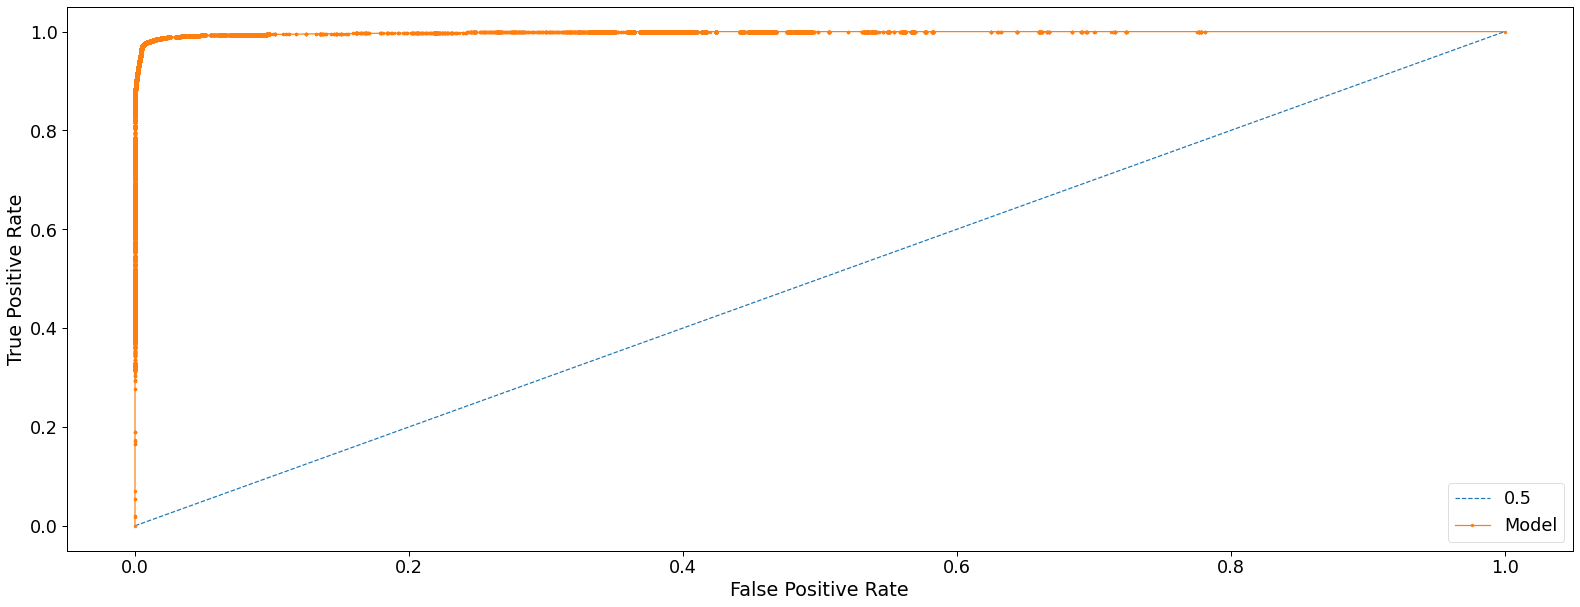

[[1268744    9511]
 [  30202 1248053]]


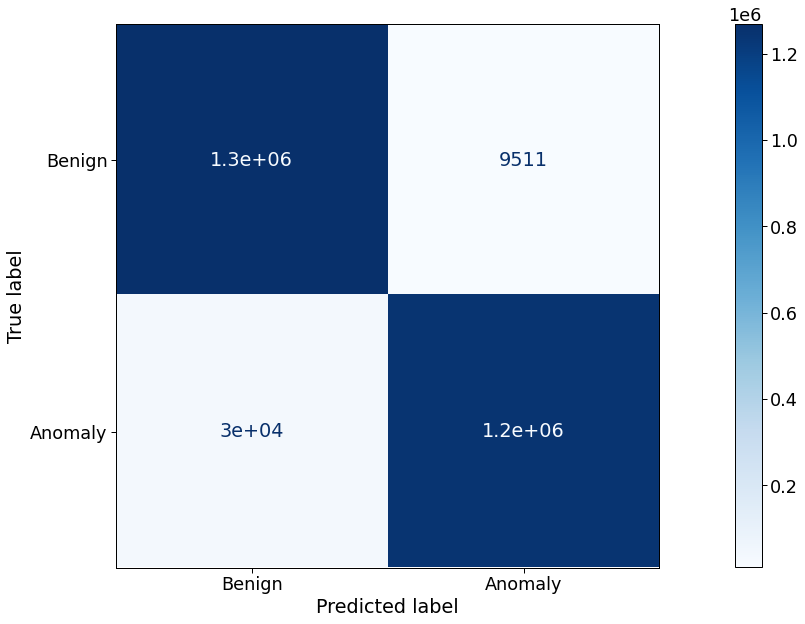

accuracy:  0.9844659320714568
f1:  0.9843391819368811
precision:  0.9924369654347611
recall:  0.9763724765402835
mcc:  0.9690588269623184


In [12]:
X_1 = np.load(folder+'X_test.npy')
y_1 = np.load(folder+'y_test.npy')

y_pred_o = clf.predict_proba(X_1)[:,1]
fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)



# Full Test Set

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  7.9min finished


Best Threshold=0.138275
Logistic: ROC AUC=0.634
Logistic: ROC AUC=0.500


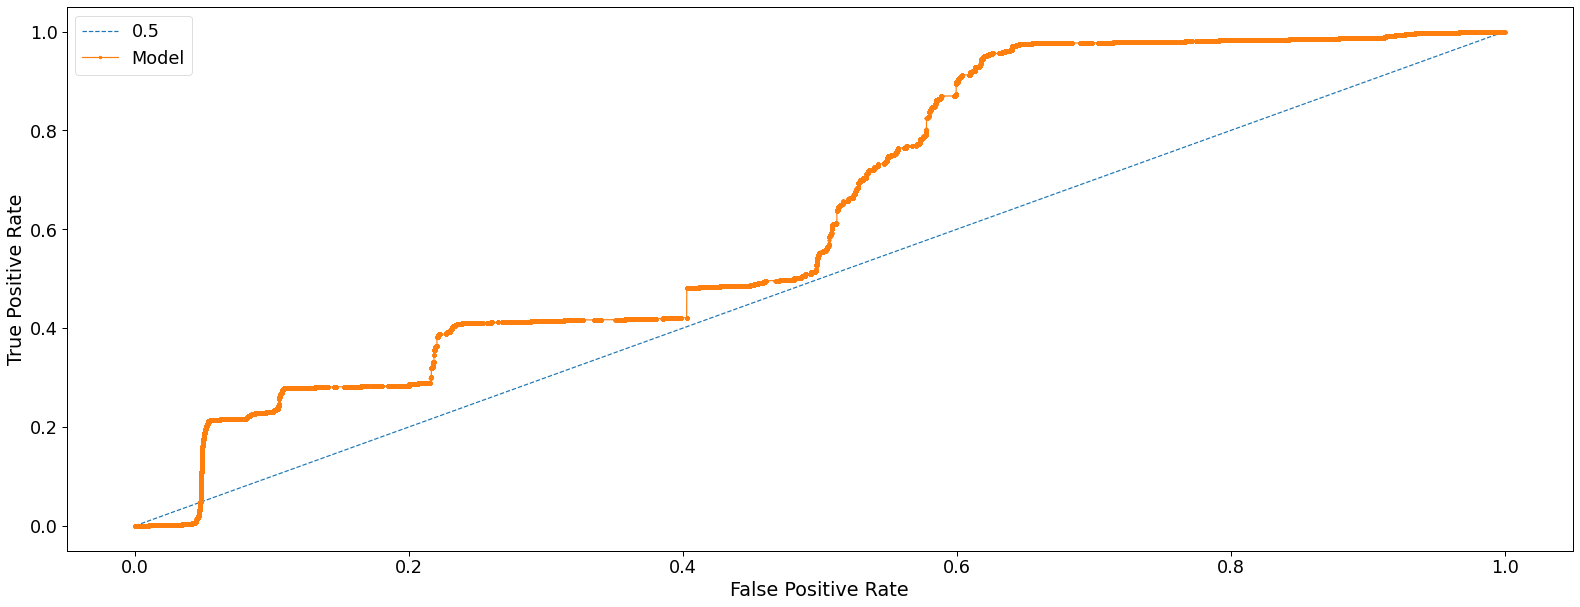

[[9580681  790065]
 [1744153  480351]]


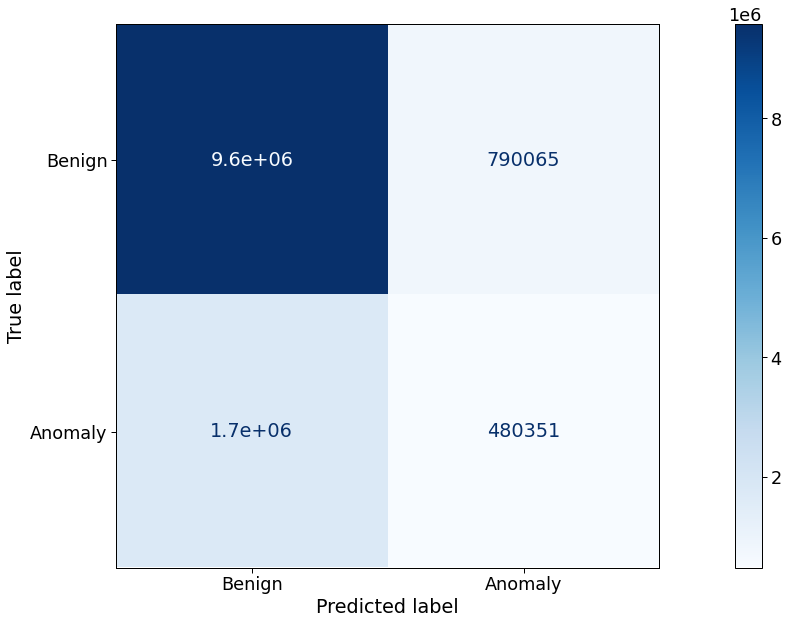

accuracy:  0.7987957364879618
f1:  0.27488526203747154
precision:  0.37810528204934446
recall:  0.21593622668244247
mcc:  0.17696908189386382
attack                    misclassification
Bot                       1                     143097
Brute Force -Web          1                       2094
Brute Force -XSS          1                        895
DDOS attack-HOIC          1                    1080858
DDoS attacks-LOIC-HTTP    0                          5
                          1                     280332
DoS attacks-GoldenEye     0                      27723
DoS attacks-Hulk          0                     432487
DoS attacks-SlowHTTPTest  1                      14116
DoS attacks-Slowloris     0                       7227
FTP-BruteForce            1                      25933
Infilteration             0                      12879
                          1                     101447
SQL Injection             1                        432
SSH-Bruteforce            0                 

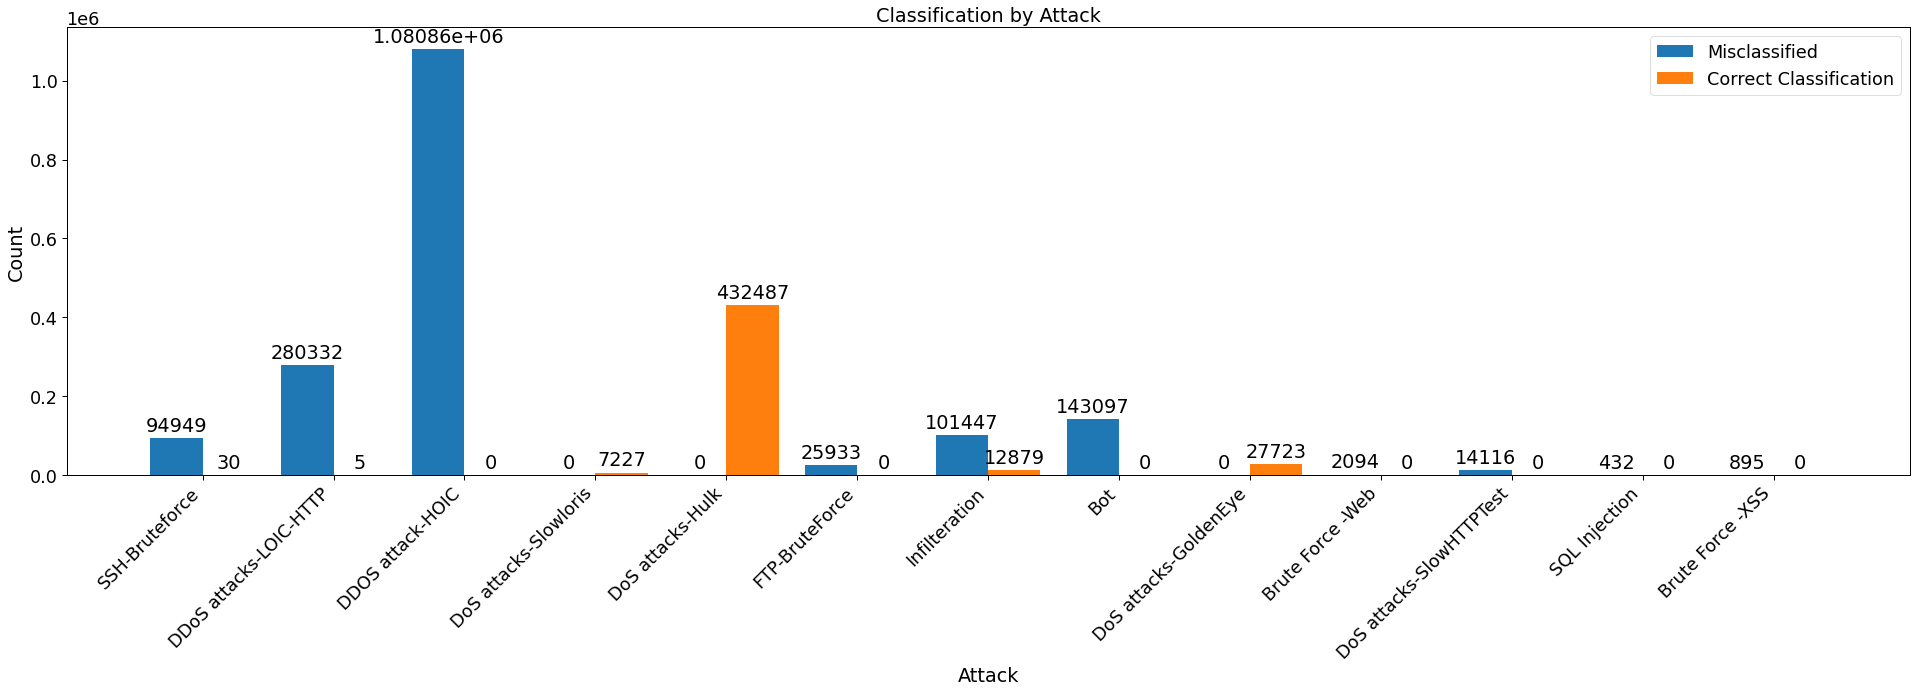

In [13]:
X_1 = np.load(folder+'X_1.npy')
y_1 = np.load(folder+'y_1.npy')
a_1 = np.load(folder+'a_1.npy',allow_pickle=True)

y_pred_o = clf.predict_proba(X_1)[:,1]
fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)
attack_report(y_pred_oround, y_1, a_1)

# Full Test Set with Threshold

Best Threshold=0.138275
[[3890290 6480456]
 [ 100340 2124164]]


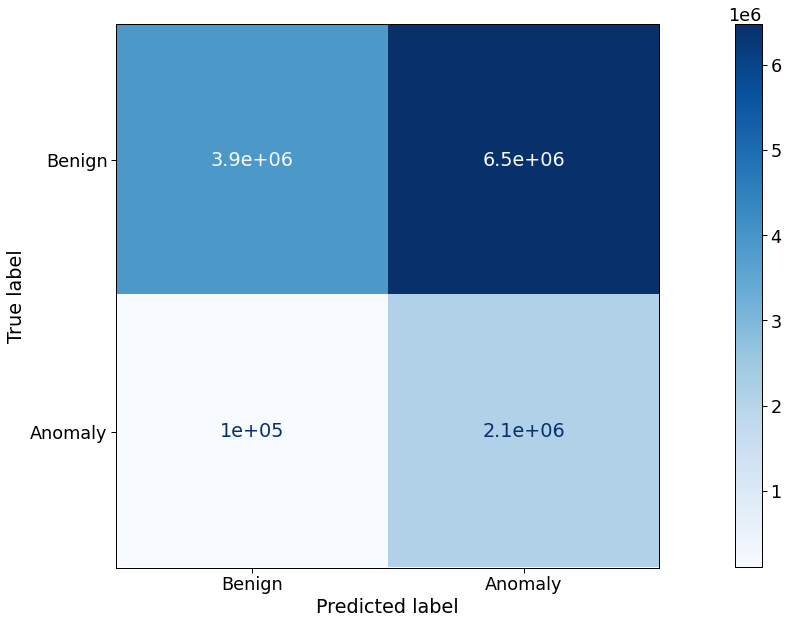

accuracy:  0.4775176356166015
f1:  0.39230578576808245
precision:  0.24686319674779364
recall:  0.9548933155435998
mcc:  0.2705007529098666
attack                    misclassification
Bot                       0                     137132
                          1                       5965
Brute Force -Web          0                       2023
                          1                         71
Brute Force -XSS          0                        863
                          1                         32
DDOS attack-HOIC          0                    1042764
                          1                      38094
DDoS attacks-LOIC-HTTP    0                     280337
DoS attacks-GoldenEye     0                      27723
DoS attacks-Hulk          0                     432487
DoS attacks-SlowHTTPTest  0                      14116
DoS attacks-Slowloris     0                       7227
FTP-BruteForce            0                      25933
Infilteration             0                   

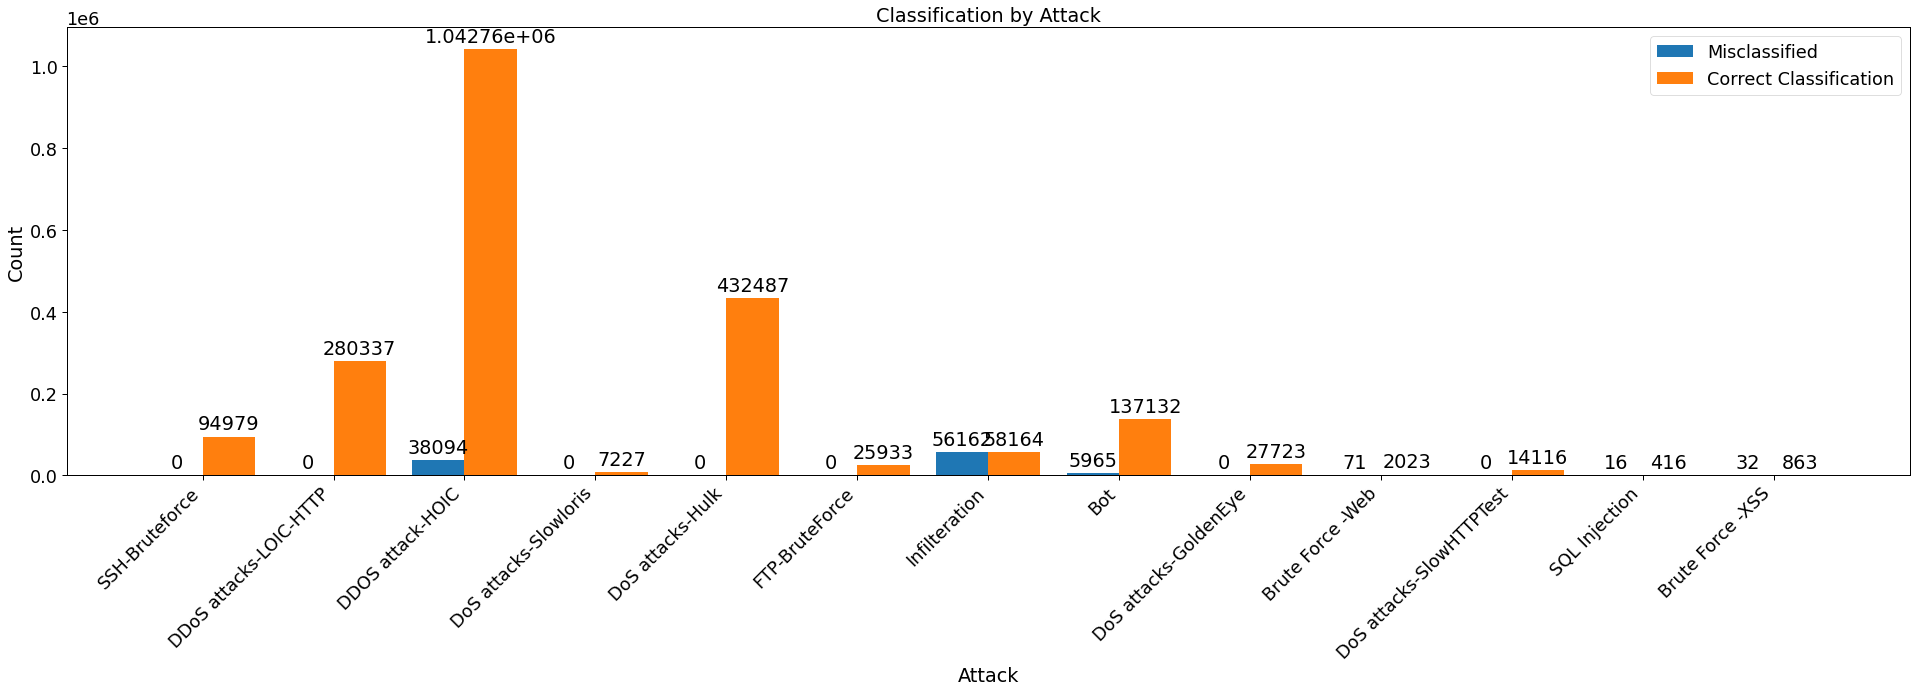

In [14]:
print('Best Threshold=%f' % (best_thresh))
y_pred2 = np.where(y_pred_o > best_thresh, 1, 0)
test_report(y_1 ,y_pred2)
attack_report(y_pred2, y_1, a_1)

# Test Set AR

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  7.0min finished


Best Threshold=0.389318
Logistic: ROC AUC=0.860
Logistic: ROC AUC=0.500


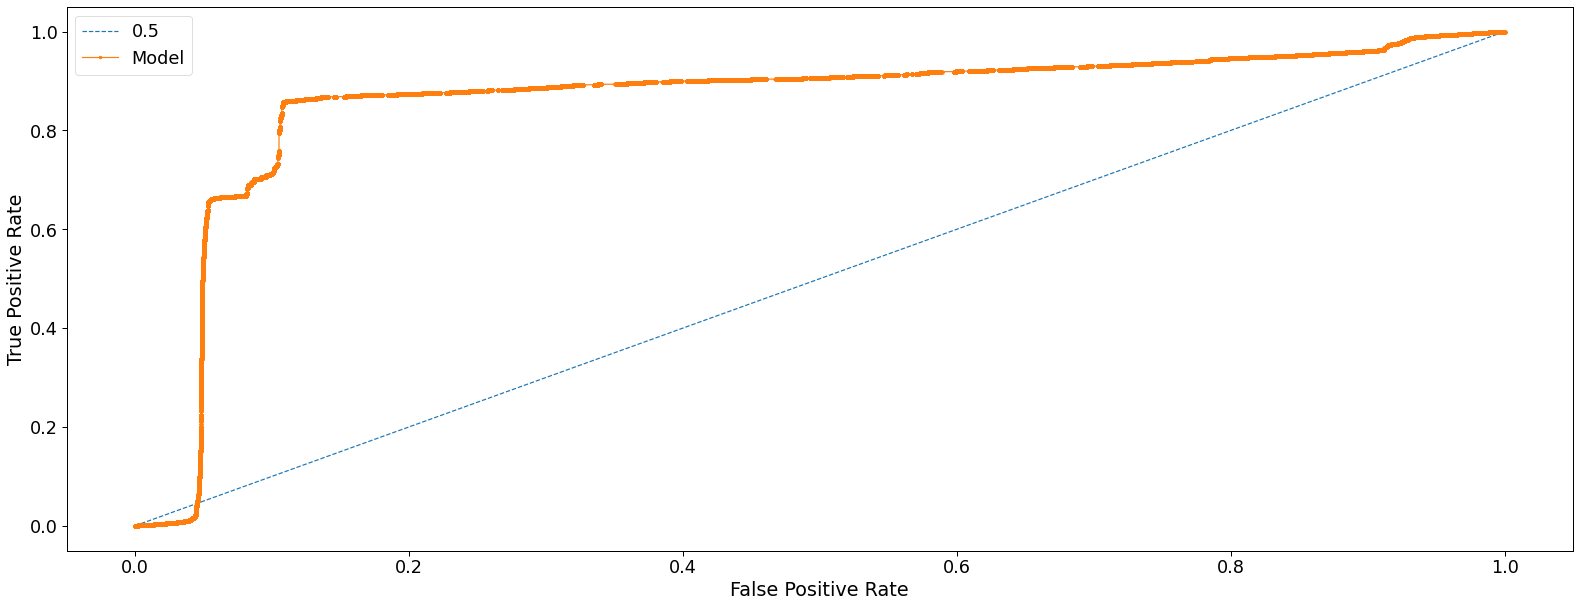

[[9580681  790065]
 [ 239866  480346]]


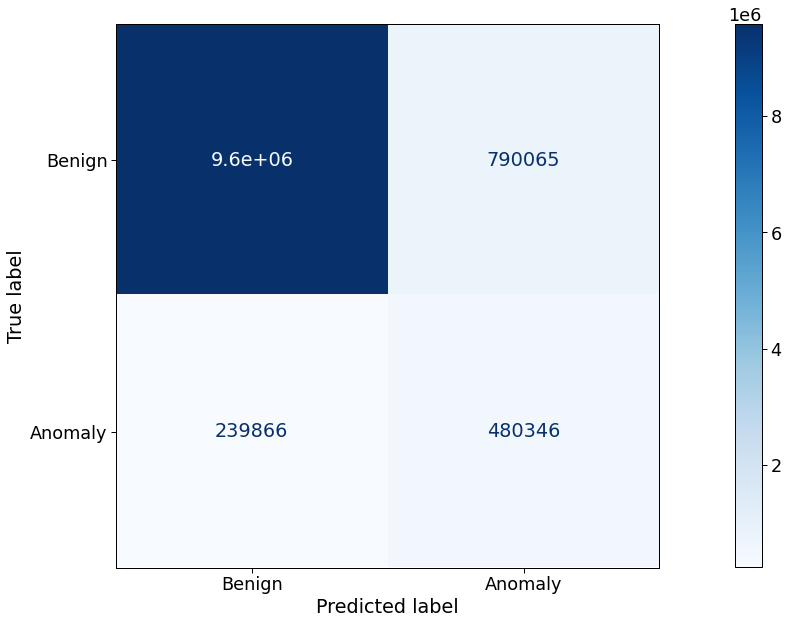

accuracy:  0.9071377783596332
f1:  0.482608710941248
precision:  0.3781028344370444
recall:  0.6669508422520036
mcc:  0.4571015951604697
attack                    misclassification
Brute Force -Web          1                      2094
Brute Force -XSS          1                       895
DoS attacks-GoldenEye     0                     27723
DoS attacks-Hulk          0                    432487
DoS attacks-SlowHTTPTest  1                     14116
DoS attacks-Slowloris     0                      7227
FTP-BruteForce            1                     25933
Infilteration             0                     12879
                          1                    101447
SQL Injection             1                       432
SSH-Bruteforce            0                        30
                          1                     94949
dtype: int64
[30, 94949]
[7227]
[432487]
[25933]
[12879, 101447]
[27723]
[2094]
[14116]
[432]
[895]


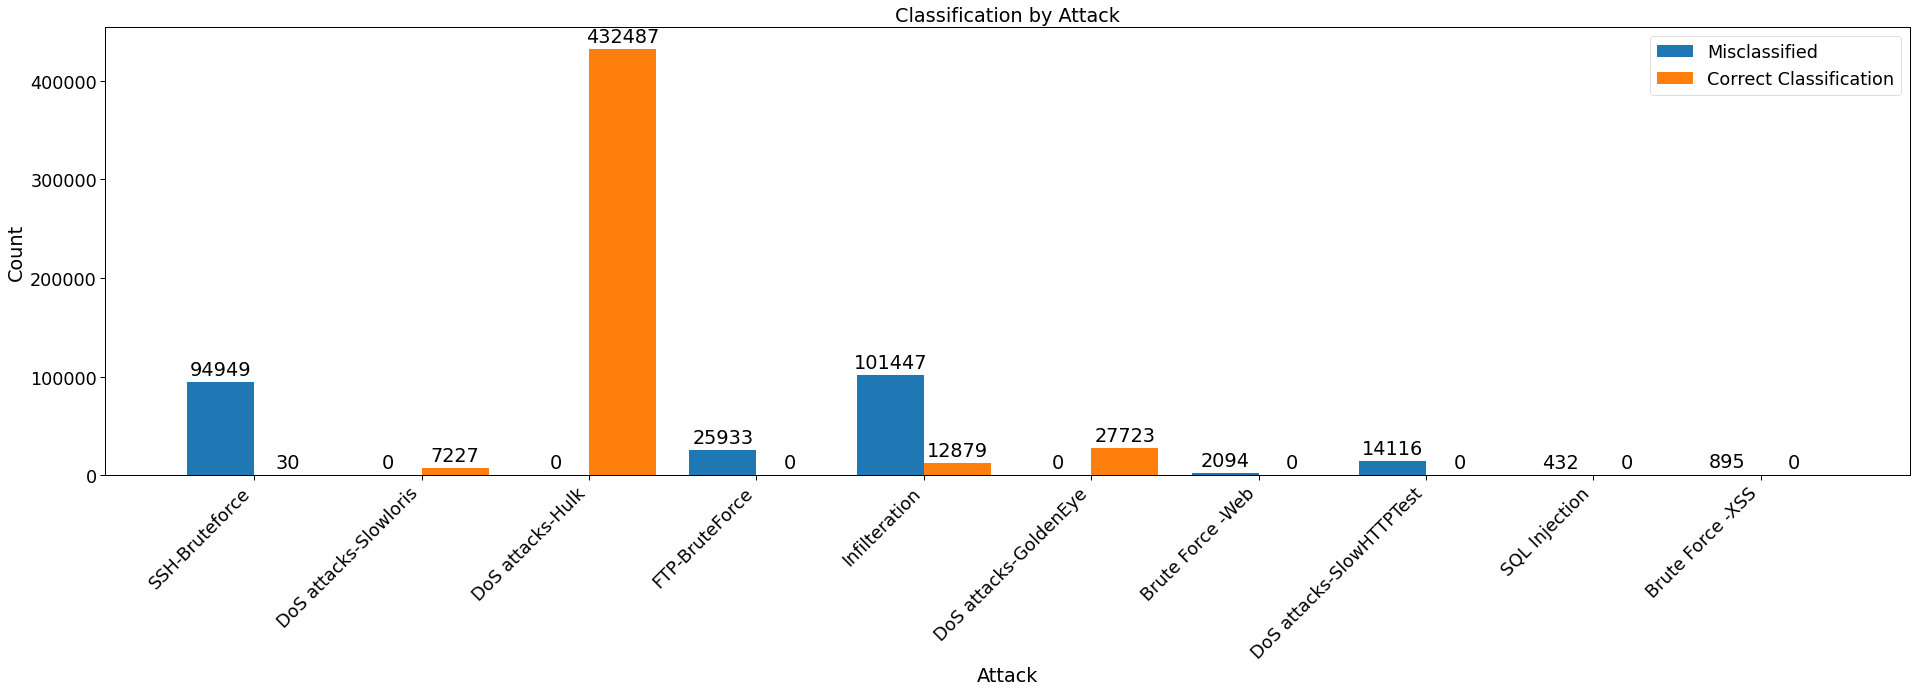

In [15]:
X_1 = np.load(folder+'X_1_ar.npy')
y_1 = np.load(folder+'y_1_ar.npy')
a_1 = np.load(folder+'a_1_ar.npy',allow_pickle=True)

y_pred_o = clf.predict_proba(X_1)[:,1]

fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)
attack_report(y_pred_oround, y_1, a_1)